## DDQN in Hockey Enviroment - Training

Train a DDQN on various Hockey env. modes

Base DQN implementation adapted from HW7

In [14]:
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import DDQN.DDQN as ddqn
from DDQN.DDQN import DDQNAgent
from DDQN.trainer import Stats, Round, train_ddqn_agent
import hockey.hockey_env as h_env

In [15]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

## Training

### Environment & Agent Initialization

In [16]:
reload(h_env)

env = h_env.HockeyEnv(mode=h_env.Mode.NORMAL)

/home/kivanc/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/kivanc/miniconda3/envs/rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [17]:
DISCOUNT = 0.90
EPS = 0.2
UPDATE_TARGET_FREQ = 20
TAU = 1e-3

agent_player = DDQNAgent(
    env.observation_space,
    env.discrete_action_space,
    discount=DISCOUNT,
    epsilon=EPS,
    update_target_freq=UPDATE_TARGET_FREQ,
    tau=TAU
)

agent_opp_weak = h_env.BasicOpponent(weak=True)
agent_opp_strong = h_env.BasicOpponent(weak=False)

In [18]:
# For the visualisation of the training progress

stats = Stats(
    returns=[],
    returns_ts=[],
    losses=[],
    losses_ts=[]
)

### Training

In [19]:
rounds = [
    Round(300, agent_opp_weak),
    Round(600, agent_opp_strong),
    Round(100, agent_opp_weak)
]

train_ddqn_agent(
    agent_player,
    env,
    max_steps=1000,
    rounds=rounds,
    stats=stats,
    ddqn_iter_fit=64,
    print_freq=100,
    tqdm=tqdm,
    verbose=True
)

Begin round 1 for 300 episodes


  0%|          | 0/300 [00:00<?, ?it/s]

Episode 1 | Return: -7.326848849100571 | Loss: 0.00264551374129951 | Done in 251 steps
Episode 101 | Return: -12.830150560415417 | Loss: 0.007684928365051746 | Done in 251 steps
Episode 201 | Return: -10.64692605685611 | Loss: 0.07670732587575912 | Done in 31 steps
Episode 300 | Return: -13.655955202155884 | Loss: 0.002518675522878766 | Done in 251 steps
Begin round 2 for 600 episodes


  0%|          | 0/600 [00:00<?, ?it/s]

Episode 1 | Return: -7.885968985299163 | Loss: 0.06956581026315689 | Done in 251 steps
Episode 101 | Return: -19.714362691373488 | Loss: 0.0055581568740308285 | Done in 251 steps
Episode 201 | Return: -13.274840745082336 | Loss: 0.0037302905693650246 | Done in 88 steps
Episode 301 | Return: -15.483596564847147 | Loss: 0.009210444055497646 | Done in 130 steps
Episode 401 | Return: -10.65139997594105 | Loss: 0.10090571641921997 | Done in 30 steps
Episode 501 | Return: -11.524403940714123 | Loss: 0.012358252890408039 | Done in 45 steps
Episode 600 | Return: -11.783698628785327 | Loss: 0.012604737654328346 | Done in 71 steps
Begin round 3 for 100 episodes


  0%|          | 0/100 [00:00<?, ?it/s]

Episode 1 | Return: -11.251817390167671 | Loss: 0.015848416835069656 | Done in 32 steps
Episode 100 | Return: -15.265486610192005 | Loss: 0.049153491854667664 | Done in 100 steps


## Agent Model Saving

In [20]:
STATE_PATH = "./DDQN/models/hockey_normal_dev/"

reload(ddqn)

agent_player.save_state(STATE_PATH)

## Visualization

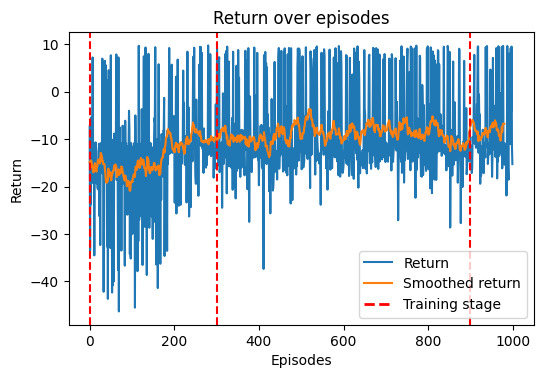

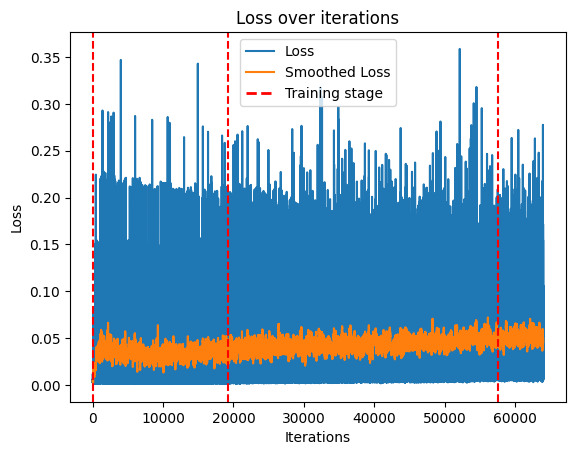

In [21]:
returns_np = np.asarray(stats.returns)
losses_np = np.asarray(stats.losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(returns_np[:,1], label="Return")
plt.plot(running_mean(returns_np[:,1],20), label="Smoothed return")
for xc in stats.returns_training_stages:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title("Return over episodes")
plt.plot([0], color='r', linestyle='--', lw=2, label='Training stage')  # Dummy plot for legend
plt.legend()
plt.show()

plt.figure()
plt.plot(losses_np, label="Loss")
plt.plot(running_mean(losses_np, 50), label="Smoothed Loss")
for xc in stats.losses_training_stages:
    plt.axvline(x=xc, color='r', linestyle='--')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.plot([0], color='r', linestyle='--', lw=2, label='Training stage')  # Dummy plot for legend
plt.legend()
plt.show()

### Rendered Demonstration Against Strong Opponent

For a more detailed evaluation, refer to `ddqn-hockey-eval.ipynb`.

In [43]:
STEPS = 100000

obs_buffer = []
reward_buffer = []
obs, _ = env.reset()
obs_agent2 = env.obs_agent_two()

for i in range(STEPS):
    env.render()
    a1_discr = agent_player.act(obs)
    a1 = env.discrete_to_continous_action(a1_discr)
    a2 = agent_opp_strong.act(obs_agent2)

    obs, r, done, trunc, _ = env.step(np.hstack([a1, a2]))
    obs_buffer.append(obs)
    reward_buffer.append(r)

    obs_agent2 = env.obs_agent_two()

    if done or trunc:
        print(f"Episode done in {i} steps")
        break


Episode done in 71 steps


In [44]:
env.close()